# Image segmentation
---

Grouping, or segmenting, images into distinct parts according to a set of features is known as image segmentation.

The simplest case for image segmentation is in background subtraction. In video and other applications, it is often the case that a human has to be isolated from a static or moving background, and so we have to use segmentation methods to distinguish these areas. Image segmentation is also used in a variety of complex recognition tasks, such as in classifying every pixel in an image of the road.

![Segmentation](images/image_segmentation.jpeg)

### Image contours
---

Edge detection algorithms are often used to detect the boundaries of objects. But, after performing edge detection you'll often be left with sets of edges that highlight not only object boundaries but also interesting features and lines. And to do image segmentation, you'll want only complete closed boundaries that marked distinct areas and objects in an image. One technique that's useful for this is called, Image Contouring.

Image contours, are continuous curves that follow the edges along a perceived boundary. So contours can be used for image segmentation and they can also provide a lot of information about the shape of an object boundary.

#### Basic imports

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
import math

#### Load and produce a binary image

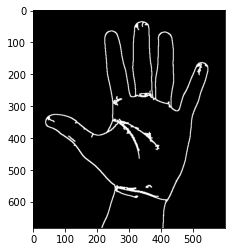

In [2]:
hand = cv2.cvtColor(cv2.imread("images/hand.jpeg"), cv2.COLOR_BGR2RGB)
gray_hand = cv2.cvtColor(hand, cv2.COLOR_RGB2GRAY)

hand_edges = cv2.Canny(gray_hand, 25, 200)

retval, binary = cv2.threshold(hand_edges, 127, 255, cv2.THRESH_BINARY)
binary = cv2.dilate(binary, np.ones((3,3)), iterations = 1)

plt.imshow(binary, cmap="gray")

#### Find and draw the contours

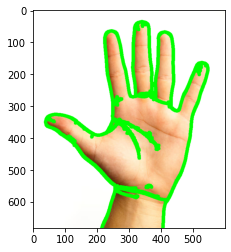

In [3]:
# Find contours in binary image
(contours, _) = cv2.findContours(hand_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

hand_copy = np.copy(hand)

all_contours = cv2.drawContours(hand_copy, contours, -1, (0,255,0), 10)

plt.imshow(all_contours)


## Contour Features

Every contour has a number of features that you can calculate, including the area of the contour, it's orientation (the direction that most of the contour is pointing in), it's perimeter, and many other properties outlined in [OpenCV documentation, here](https://docs.opencv.org/4.5.5/dd/d49/tutorial_py_contour_features.html).

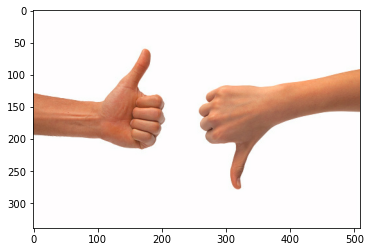

In [4]:
# Read in the image
image = cv2.imread('images/thumbs_up_down.jpg')

# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

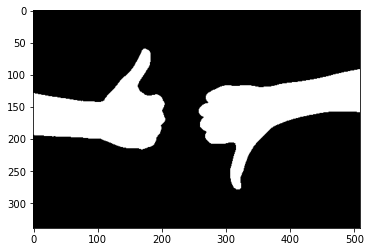

In [5]:
# Convert to grayscale
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Create a binary thresholded image
retval, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap='gray')

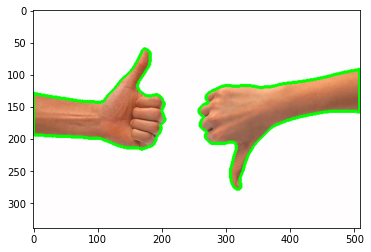

In [6]:
# Find contours from thresholded, binary image
(contours, _) = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the original image
contours_image = np.copy(image)
contours_image = cv2.drawContours(contours_image, contours, -1, (0,255,0), 3)

plt.imshow(contours_image)

### Moments

Image moments help you to calculate some features like center of mass of the object, area of the object etc. Check out the wikipedia page on [Image Moments](https://en.wikipedia.org/wiki/Image_moment).

The function cv.moments() gives a dictionary of all moment values calculated. From this moments, you can extract useful data like area, centroid etc. Centroid is given by the relations, $Cx=\frac{M_{10}}{M_{00}}$ and $Cy=\frac{M_{01}}{M_{00}}$. This can be done as follows:


Centroid 0: (371 , 155)
Centroid 1: (112 , 160)


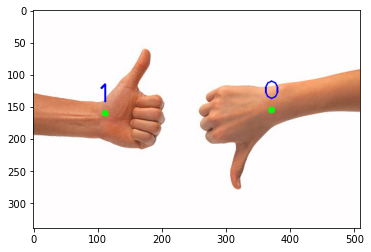

In [77]:
cropped_image = np.copy(image)

for idx, selected_contour in enumerate(contours):
    if(selected_contour is not None):
        moments = cv2.moments(selected_contour)

        cx = int(moments['m10']/moments['m00'])
        cy = int(moments['m01']/moments['m00'])

        print(f'Centroid {idx}: ({cx} , {cy})')

        cv2.circle(cropped_image, (cx, cy), 5, (0, 255, 0), -1)

        cv2.putText(cropped_image, str(idx), (cx-15, cy-15), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 2, cv2.LINE_8)

plt.imshow(cropped_image)
    

### Contour area

Contour area is given by the function cv.contourArea() or from moments, M['m00'].

In [58]:
for idx, selected_contour in enumerate(contours):
    if(selected_contour is not None):
        area = cv2.arcLength(selected_contour, True)

        print(f'Area {idx}: {area}')

Area 0: 817.5289995670319
Area 1: 698.4579323530197


### Orientation

The orientation of an object is the angle at which an object is directed. To find the angle of a contour, you should first find an ellipse that fits the contour and then extract the `angle` from that shape.
 
```python
# Fit an ellipse to a contour and extract the angle from that ellipse
(x,y), (MA,ma), angle = cv2.fitEllipse(selected_contour)
```

**Orientation values**

These orientation values are in degrees measured from the x-axis. A value of zero means a flat line, and a value of 90 means that a contour is pointing straight up.

So, the orientation angles that you calculated for each contour should be able to tell us something about the general position of the hand. The hand with it's thumb up, should have a higher (closer to 90 degrees) orientation than the hand with it's thumb down.

Angles of each contour (in degrees): [61.35833740234375, 82.27550506591797]


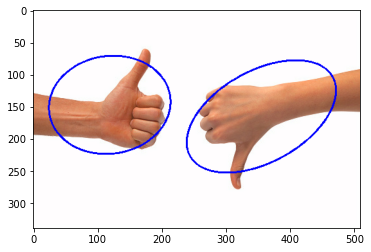

In [65]:
# Create an empty list to store the angles in
angles = []
angles_image = np.copy(image)

for contour in contours:
    center, axes, angle = cv2.fitEllipse(contour)
    ellipse = cv2.fitEllipse(contour)
    center = np.int0(center)
    axes = (axes[0]*0.5, axes[1]*0.5)
    axes = np.int0(axes)
    angles.append(angle)

    cv2.ellipse(angles_image, center, axes, angle, 0, 360, (0,0,255), 2)
    
print(f'Angles of each contour (in degrees): {angles}')

plt.imshow(angles_image)

### Bounding rectangle

There are two types of bounding rectangles:

**Straight Bounding Rectangle**

It is a straight rectangle, it doesn't consider the rotation of the object. So area of the bounding rectangle won't be minimum. It is found by the function cv2.boundingRect().

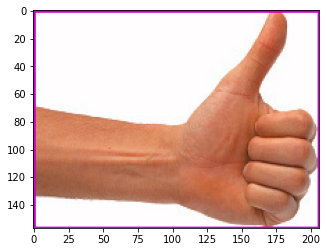

In [18]:
# Isolate a part of the image based on the contours
selected_contour = contours[angles.index(max(angles))]

if(selected_contour is not None):
    cropped_image = np.copy(image)
    
    # Find the bounding rectangle of a selected contour
    x,y,w,h = cv2.boundingRect(selected_contour)

    # Draw the bounding rectangle as a purple box
    _ = cv2.rectangle(cropped_image, (x,y), (x+w,y+h), (200,0,200),2)
    
    cropped_image = cropped_image[y: y + h, x: x + w] 
    plt.imshow(cropped_image)

**Rotated Rectangle**

Here, bounding rectangle is drawn with minimum area, so it considers the rotation also. The function used is cv.minAreaRect(). It returns a Box2D structure which contains following details - ( center (x,y), (width, height), angle of rotation ). But to draw this rectangle, we need 4 corners of the rectangle. It is obtained by the function cv.boxPoints().

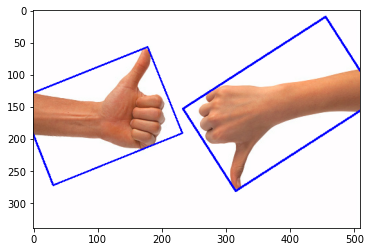

In [20]:
cropped_image = np.copy(image)

for selected_contour in contours:
    if(selected_contour is not None):
        
        rect = cv2.minAreaRect(selected_contour)
        box = cv2.boxPoints(rect)
        
        box = np.int0(box)
        
        cv2.drawContours(cropped_image, [box], 0, (0,0,255), 2)

plt.imshow(cropped_image)

### Minimum enclosing Circle

It is a circle which completely covers the object with minimum area. To find it we use the function cv.minEnclosingCircle().

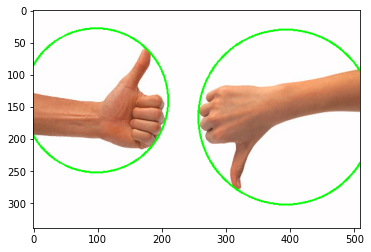

In [66]:
cropped_image = np.copy(image)

for selected_contour in contours:
    if(selected_contour is not None):
        
        (x,y),radius = cv2.minEnclosingCircle(selected_contour)
        center = np.int0((x,y))
        radius = int(radius)
        cv2.circle(cropped_image,center,radius,(0,255,0),2)

plt.imshow(cropped_image)